   Unnamed: 0 Subject ID         MRI ID        Group  Visit  MR Delay M/F  \
0           0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M   
1           1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M   
2           2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M   
3           3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M   
4           5  OAS2_0004  OAS2_0004_MR1  Nondemented      1         0   F   

  Hand  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0    R   87    14  2.0  27.0  0.0  1987  0.696  0.883  
1    R   88    14  2.0  30.0  0.0  2004  0.681  0.876  
2    R   75    12  NaN  23.0  0.5  1678  0.736  1.046  
3    R   76    12  NaN  28.0  0.5  1738  0.713  1.010  
4    R   88    18  3.0  28.0  0.0  1215  0.710  1.444  
Summary statistics of CDR scores by demographic factors:
                                           CDR                 
                                          mean median       std
gender dementia_

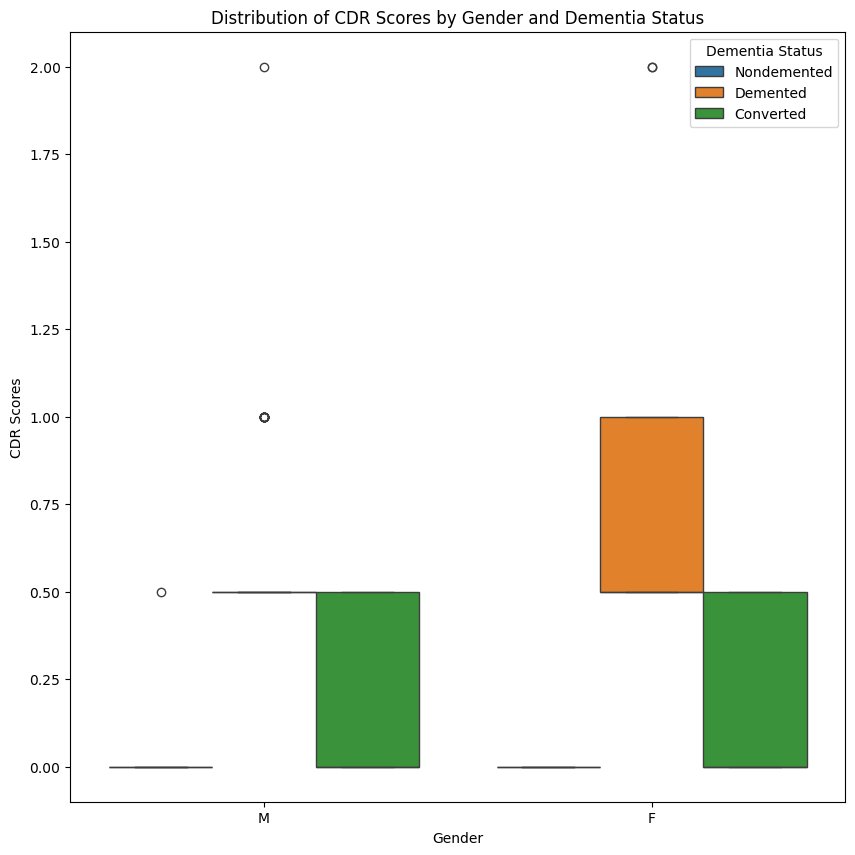

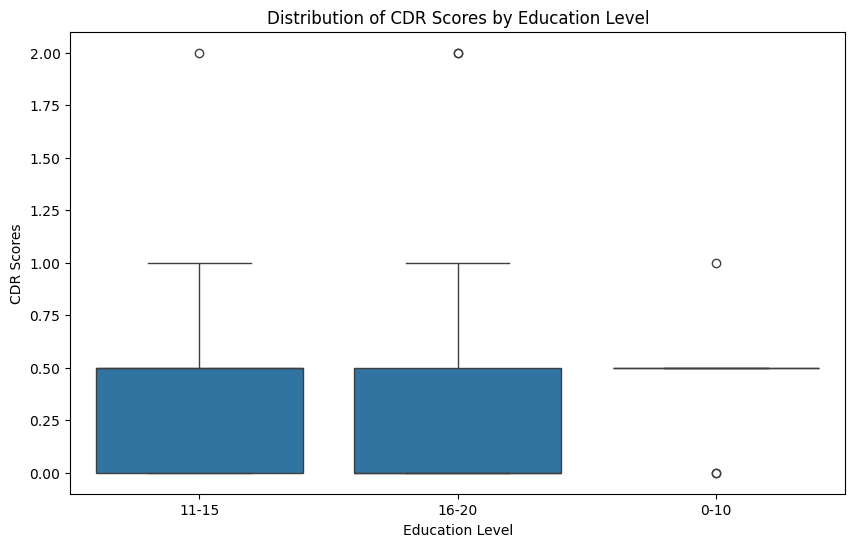

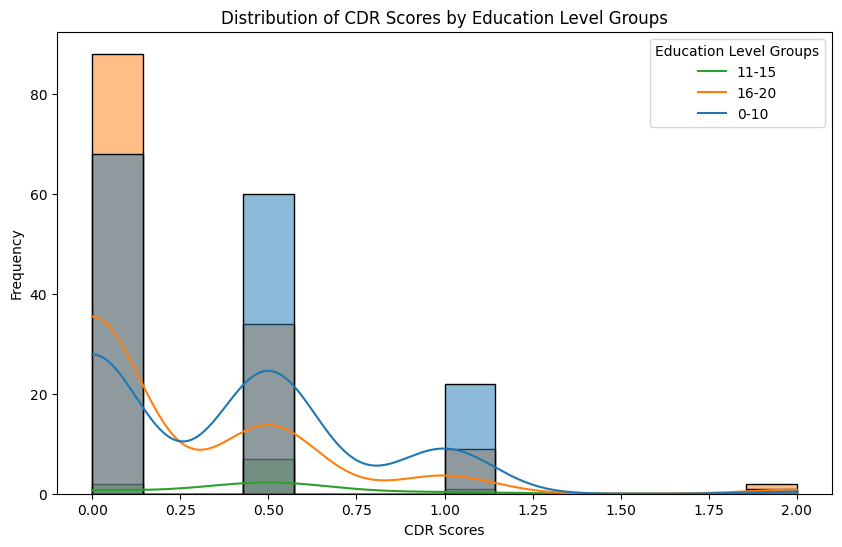

ANOVA for Age on CDR scores:
  Source  ddof1  ddof2         F     p-unc       np2
0    age     37    256  1.625477  0.016585  0.190239

ANOVA for Gender on CDR scores:
   Source  ddof1  ddof2         F     p-unc       np2
0  gender      1    292  9.102014  0.002778  0.030229

ANOVA for Dementia Status on CDR scores:
            Source  ddof1  ddof2           F         p-unc       np2
0  dementia_status      2    291  326.532486  4.301855e-75  0.691759
Error during ANOVA analysis: cannot convert float NaN to integer
Error during ANOVA analysis: cannot convert float NaN to integer


<ipython-input-28-8c2cbcdfb7d7>:118: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[['CDR', 'age', 'gender', 'dementia_status']].corr()



Correlation Matrix:
          CDR       age
CDR  1.000000  0.010679
age  0.010679  1.000000
Sample size needed: 45.45


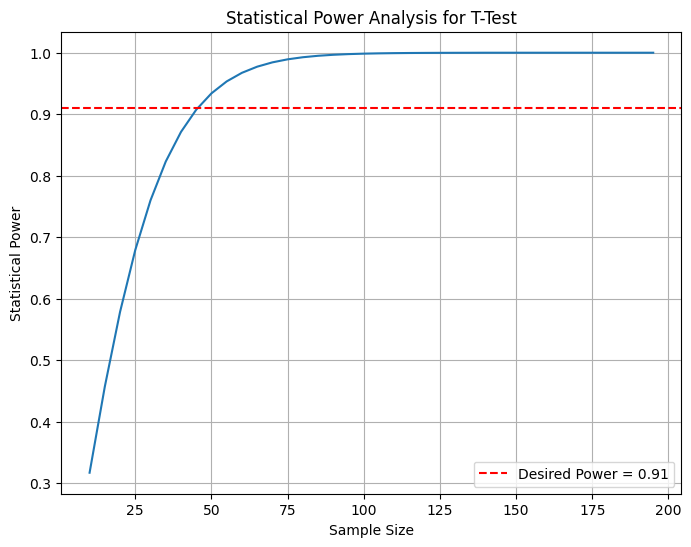

In [28]:
import numpy as np
import pandas as pd
import piplite
await piplite.install('seaborn')
import seaborn as sns
%pip install pingouin
import pingouin as pg
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
from statsmodels.regression.mixed_linear_model import MixedLM


# Load and clean the dataset
df = pd.read_csv('INF2178_A4_data.csv')

# Examine the dataset
print(df.head())

# Drop irrelevant columns
df.drop(columns=['Visit', 'MR Delay', 'Hand', 'SES', 'MMSE','eTIV', 'nWBV', 'ASF'], inplace=True)

# Replace column names
df = df.rename(columns={'M/F':'gender', 'Group':'dementia_status', 'EDUC':'education_lvl', 'Age':'age'})

# Identify and handle NaN values
columns_with_nan = ['age', 'gender', 'CDR']  # Specify columns of interest
df = df.dropna(subset=columns_with_nan)  # Drop rows with NaN values in specified columns

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Check if there are any remaining NaN values in the cleaned DataFrame
if df.isna().any().any():
    print("Warning: NaN values still present after cleaning.")

In [ ]:
# Data Exploration
# Descriptive statistics by gender, dementia status, and education level
cdr_summary = df.groupby(['gender', 'dementia_status', 'education_lvl']).agg({'CDR': ['mean', 'median', 'std']})
print("Summary statistics of CDR scores by demographic factors:")
print(cdr_summary)

# Boxplot of CDR scores by gender and dementia status
plt.figure(figsize=(10, 10))
sns.boxplot(x='gender', y='CDR', hue='dementia_status', data=df)
plt.title('Distribution of CDR Scores by Gender and Dementia Status')
plt.xlabel('Gender')
plt.ylabel('CDR Scores')
plt.legend(title='Dementia Status')
plt.show()

# Define a function to map education levels to grouped categories
def map_education_group(education_level):
    if education_level <= 10:
        return '0-10'
    elif education_level <= 15:
        return '11-15'
    else:
        return '16-20'

# Apply the function to create a new column 'Education Group'
df['education_group'] = df['education_lvl'].apply(map_education_group)

# Boxplot of CDR scores by Education level
plt.figure(figsize=(10, 6))
sns.boxplot(x='education_group', y='CDR', data=df)
plt.title('Distribution of CDR Scores by Education Level')
plt.xlabel('Education Level')
plt.ylabel('CDR Scores')
plt.show()

# Histogram of CDR scores by education level
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='CDR', hue='education_group', kde=True)
plt.title('Distribution of CDR Scores by Education Level Groups')
plt.xlabel('CDR Scores')
plt.ylabel('Frequency')

# Get the unique education levels from the dataset
education_levels = df['education_group'].unique()

# Create a legend with labels for each education level
plt.legend(title='Education Level Groups', labels=education_levels)

plt.show()

In [ ]:
# # Quantitative Analysis: Mixed-Effects ANOVA Models
# Individual ANOVA for Age
age_anova = pg.anova(data=df, dv='CDR', between='age')
print("ANOVA for Age on CDR scores:")
print(age_anova)

# Individual ANOVA for Gender
gender_anova = pg.anova(data=df, dv='CDR', between='gender')
print("\nANOVA for Gender on CDR scores:")
print(gender_anova)

# Individual ANOVA for Dementia Status
dementia_anova = pg.anova(data=df, dv='CDR', between='dementia_status')
print("\nANOVA for Dementia Status on CDR scores:")
print(dementia_anova)

# Interaction Analysis: Age vs. Gender
try:
    interaction_age_gender = pg.mixed_anova(data=df, dv='CDR', within='age', subject='Subject ID', between='gender')
    print("\nInteraction between Age and Gender on CDR scores:")
    print(interaction_age_gender)
except ValueError as e:
    print("Error during ANOVA analysis:", e)

# Interaction Analysis: Age vs. Dementia Status
try:
    interaction_age_dementia = pg.mixed_anova(data=df, dv='CDR', within='age', between='dementia_status', subject='Subject ID')
    print("\nInteraction between Age and Dementia Status on CDR scores:")
    print(interaction_age_dementia)
except ValueError as e:
    print("Error during ANOVA analysis:", e)

# Correlation Analysis
correlation_matrix = df[['CDR', 'age', 'gender', 'dementia_status']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [ ]:
# Statistical Power Analysis for T-Tests
# Define parameters
alpha = 0.05          # Significance level
power = 0.91          # Desired statistical power
effect_size = 0.7     # Effect size

# Initialize TTestIndPower object
power_analysis = TTestIndPower()

# Calculate sample size needed for specified power, alpha, and effect size
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)

print(f"Sample size needed: {sample_size:.2f}")

# Plotting the power curve for the specified effect size and alpha
plt.figure(figsize=(8, 6))
sample_sizes = np.arange(10, 200, 5)
statistical_power = [power_analysis.solve_power(effect_size=effect_size, nobs1=n, alpha=alpha) for n in sample_sizes]
plt.plot(sample_sizes, statistical_power)
plt.axhline(power, color='r', linestyle='--', label=f'Desired Power = {power}')
plt.xlabel('Sample Size')
plt.ylabel('Statistical Power')
plt.title('Statistical Power Analysis for T-Test')
plt.legend()
plt.grid(True)
plt.show()